# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [3]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [4]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for a days in period 2011-01-01 to 2019-12-31 (9 years);

In [5]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [6]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (29780, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,8.632311,8.728203,8.630313,5.265025,576145,ABEV3.SA,0
1,2011-01-03,15.750000,15.900000,15.690000,2.838269,6626800,BBAS3.SA,0
2,2011-01-03,11.809763,11.927362,11.724237,6.688094,10862336,BBDC4.SA,0
3,2011-01-03,18.031555,18.250118,17.963253,10.171994,10014663,ITUB4.SA,0
4,2011-01-03,8.422694,8.629907,8.422694,6.294306,3652542,LREN3.SA,0
...,...,...,...,...,...,...,...,...
29775,2022-12-29,24.990000,25.049999,24.430000,18.930288,57901800,PETR4.SA,3
29776,2022-12-29,37.250000,37.480000,36.619999,37.150330,7890300,PRIO3.SA,3
29777,2022-12-29,54.300869,55.776001,52.626392,51.326019,8786791,RENT3.SA,3
29778,2022-12-29,89.000000,89.949997,88.830002,80.014046,40110800,VALE3.SA,3


In [7]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2978,2978,2978,2978,2978,2978,2978
BBAS3.SA,2978,2978,2978,2978,2978,2978,2978
BBDC4.SA,2978,2978,2978,2978,2978,2978,2978
ITUB4.SA,2978,2978,2978,2978,2978,2978,2978
LREN3.SA,2978,2978,2978,2978,2978,2978,2978
PETR4.SA,2978,2978,2978,2978,2978,2978,2978
PRIO3.SA,2978,2978,2978,2978,2978,2978,2978
RENT3.SA,2978,2978,2978,2978,2978,2978,2978
VALE3.SA,2978,2978,2978,2978,2978,2978,2978


### Normalize Data

In [8]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df

/home/caio/Documentos/FinRL/finrl/meta/preprocessor/preprocessors.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00200262 0.00114137 0.0010422  ... 0.04565734 0.05214546 0.07760399]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/home/caio/Documentos/FinRL/finrl/meta/preprocessor/preprocessors.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,tic,day
0,2011-01-03,0.353928,0.355383,0.359147,0.272027,0.002003,ABEV3.SA,0.00
1,2011-01-03,0.566547,0.568771,0.572419,0.157351,0.014581,BBAS3.SA,0.00
2,2011-01-03,0.396939,0.397479,0.399922,0.287841,0.021760,BBDC4.SA,0.00
3,2011-01-03,0.466293,0.458661,0.467793,0.322621,0.062331,ITUB4.SA,0.00
4,2011-01-03,0.153498,0.157120,0.155466,0.127001,0.072591,LREN3.SA,0.00
...,...,...,...,...,...,...,...,...
29775,2022-12-29,0.663745,0.652514,0.662958,0.694899,0.082841,PETR4.SA,0.75
29776,2022-12-29,0.858295,0.844144,0.878173,0.857373,0.048724,PRIO3.SA,0.75
29777,2022-12-29,0.737949,0.754746,0.727218,0.728887,0.097191,RENT3.SA,0.75
29778,2022-12-29,0.742905,0.746783,0.770759,0.916710,0.218546,VALE3.SA,0.75


In [9]:
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [10]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [11]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [12]:
DRLAgent.train_model(model, episodes=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 396608.8125
Final accumulative portfolio value: 3.966088125
Maximum DrawDown: -0.44438344422921683
Sharpe ratio: 0.8457265722481079


  5%|▌         | 1/20 [00:21<06:56, 21.92s/it]

Initial portfolio value:100000
Final portfolio value: 516058.15625
Final accumulative portfolio value: 5.1605815625
Maximum DrawDown: -0.4995211840863226
Sharpe ratio: 0.9424076497625826


 10%|█         | 2/20 [00:41<06:06, 20.38s/it]

Initial portfolio value:100000
Final portfolio value: 653303.1875
Final accumulative portfolio value: 6.533031875
Maximum DrawDown: -0.4932240642518143
Sharpe ratio: 1.039128550544465


 15%|█▌        | 3/20 [01:00<05:40, 20.01s/it]

Initial portfolio value:100000
Final portfolio value: 727457.9375
Final accumulative portfolio value: 7.274579375
Maximum DrawDown: -0.5916939437071992
Sharpe ratio: 0.9755888805224197


 20%|██        | 4/20 [01:21<05:22, 20.15s/it]

Initial portfolio value:100000
Final portfolio value: 888727.4375
Final accumulative portfolio value: 8.887274375
Maximum DrawDown: -0.5833230770194369
Sharpe ratio: 1.054493551675733


 25%|██▌       | 5/20 [01:40<04:56, 19.77s/it]

Initial portfolio value:100000
Final portfolio value: 1050897.125
Final accumulative portfolio value: 10.50897125
Maximum DrawDown: -0.620961225640315
Sharpe ratio: 1.0348898146101055


 30%|███       | 6/20 [01:59<04:32, 19.46s/it]

Initial portfolio value:100000
Final portfolio value: 1023424.6875
Final accumulative portfolio value: 10.234246875
Maximum DrawDown: -0.7085715090168286
Sharpe ratio: 0.9318059254056417


 35%|███▌      | 7/20 [02:18<04:11, 19.31s/it]

Initial portfolio value:100000
Final portfolio value: 1336816.0
Final accumulative portfolio value: 13.36816
Maximum DrawDown: -0.6709798674401002
Sharpe ratio: 1.0178325763882272


 40%|████      | 8/20 [02:38<03:54, 19.57s/it]

Initial portfolio value:100000
Final portfolio value: 1143736.125
Final accumulative portfolio value: 11.43736125
Maximum DrawDown: -0.7354478728644616
Sharpe ratio: 0.9193824798766184


 45%|████▌     | 9/20 [02:58<03:36, 19.67s/it]

Initial portfolio value:100000
Final portfolio value: 1447926.75
Final accumulative portfolio value: 14.4792675
Maximum DrawDown: -0.6606099188956789
Sharpe ratio: 1.0426895812500747


 50%|█████     | 10/20 [03:17<03:16, 19.64s/it]

Initial portfolio value:100000
Final portfolio value: 1388103.5
Final accumulative portfolio value: 13.881035
Maximum DrawDown: -0.7314412203191789
Sharpe ratio: 0.9540679433785886


 55%|█████▌    | 11/20 [03:37<02:57, 19.69s/it]

Initial portfolio value:100000
Final portfolio value: 1462361.75
Final accumulative portfolio value: 14.6236175
Maximum DrawDown: -0.708401396275495
Sharpe ratio: 0.9871769147637509


 60%|██████    | 12/20 [03:57<02:38, 19.78s/it]

Initial portfolio value:100000
Final portfolio value: 1502600.0
Final accumulative portfolio value: 15.026
Maximum DrawDown: -0.7146236159588429
Sharpe ratio: 0.9785650297770141


 65%|██████▌   | 13/20 [04:17<02:18, 19.81s/it]

Initial portfolio value:100000
Final portfolio value: 1407372.25
Final accumulative portfolio value: 14.0737225
Maximum DrawDown: -0.7238039563369632
Sharpe ratio: 0.957072817787843


 70%|███████   | 14/20 [04:36<01:58, 19.71s/it]

Initial portfolio value:100000
Final portfolio value: 1659994.0
Final accumulative portfolio value: 16.59994
Maximum DrawDown: -0.6847477717585057
Sharpe ratio: 1.0264787047464128


 75%|███████▌  | 15/20 [04:56<01:38, 19.72s/it]

Initial portfolio value:100000
Final portfolio value: 1558470.375
Final accumulative portfolio value: 15.58470375
Maximum DrawDown: -0.7103304746937166
Sharpe ratio: 0.9817716062882216


 80%|████████  | 16/20 [05:16<01:19, 19.77s/it]

Initial portfolio value:100000
Final portfolio value: 1717809.875
Final accumulative portfolio value: 17.17809875
Maximum DrawDown: -0.6834646682868349
Sharpe ratio: 1.0230833111018989


 85%|████████▌ | 17/20 [05:36<00:59, 19.82s/it]

Initial portfolio value:100000
Final portfolio value: 1749218.875
Final accumulative portfolio value: 17.49218875
Maximum DrawDown: -0.6856467600220921
Sharpe ratio: 1.0217001383266016


 90%|█████████ | 18/20 [05:55<00:39, 19.71s/it]

Initial portfolio value:100000
Final portfolio value: 1886899.5
Final accumulative portfolio value: 18.868995
Maximum DrawDown: -0.6649575136780643
Sharpe ratio: 1.0515395833479706


 95%|█████████▌| 19/20 [06:16<00:19, 19.85s/it]

Initial portfolio value:100000
Final portfolio value: 1964975.625
Final accumulative portfolio value: 19.64975625
Maximum DrawDown: -0.6752240184578997
Sharpe ratio: 1.0547723536582954


100%|██████████| 20/20 [06:35<00:00, 19.79s/it]


### Save Model

In [13]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [18]:
environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [19]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 347603.125
Final accumulative portfolio value: 3.47603125
Maximum DrawDown: -0.44513507812499997
Sharpe ratio: 2.1144462407713482
Initial portfolio value:100000
Final portfolio value: 145157.78125
Final accumulative portfolio value: 1.4515778125
Maximum DrawDown: -0.134578804704783
Sharpe ratio: 1.5728490904951775
Initial portfolio value:100000
Final portfolio value: 99787.6484375
Final accumulative portfolio value: 0.997876484375
Maximum DrawDown: -0.020480036050520067
Sharpe ratio: -0.10804711516201167


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [20]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 422018.9375
Final accumulative portfolio value: 4.220189375
Maximum DrawDown: -0.471917543402012
Sharpe ratio: 0.807427881577562
Initial portfolio value:100000
Final portfolio value: 171398.328125
Final accumulative portfolio value: 1.71398328125
Maximum DrawDown: -0.2507890625
Sharpe ratio: 1.7169331225232267
Initial portfolio value:100000
Final portfolio value: 96248.6171875
Final accumulative portfolio value: 0.962486171875
Maximum DrawDown: -0.16938549037620354
Sharpe ratio: -0.12241451345277976
Initial portfolio value:100000
Final portfolio value: 113848.4921875
Final accumulative portfolio value: 1.138484921875
Maximum DrawDown: -0.1664581716818163
Sharpe ratio: 0.8294364886256772


### Plot graphics

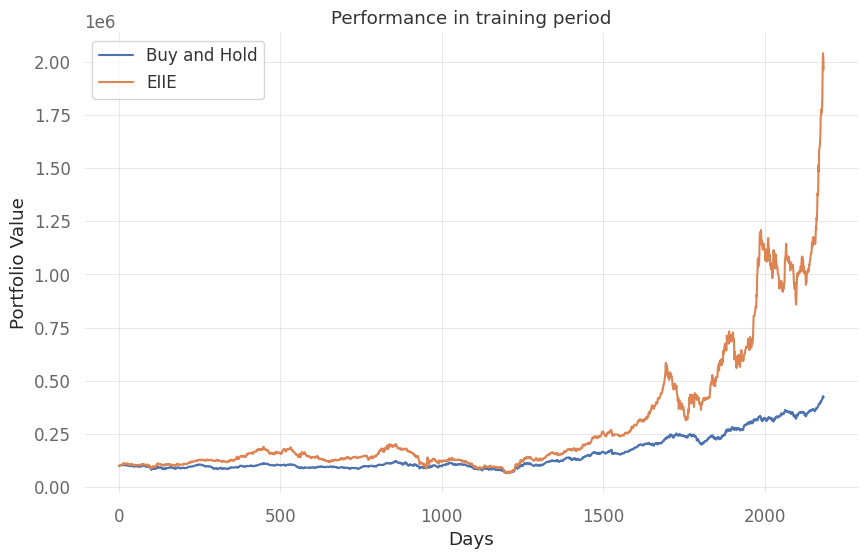

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

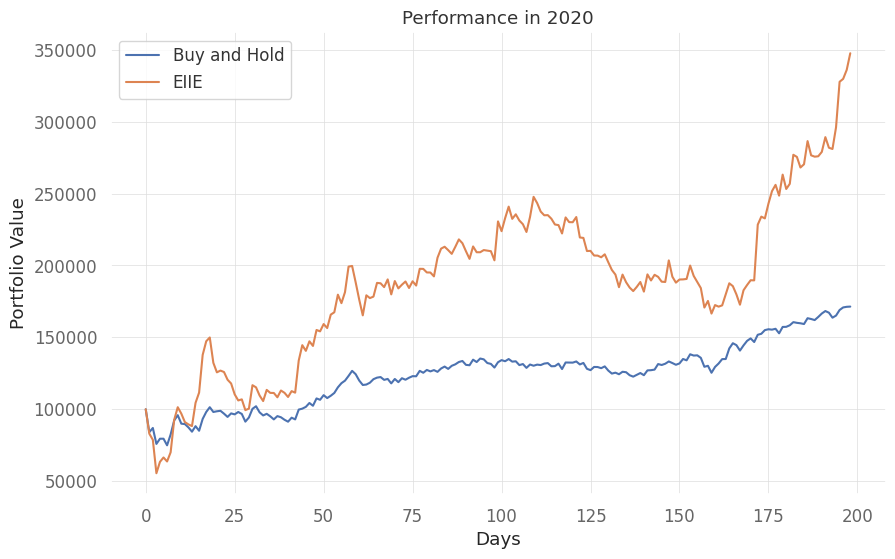

In [22]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

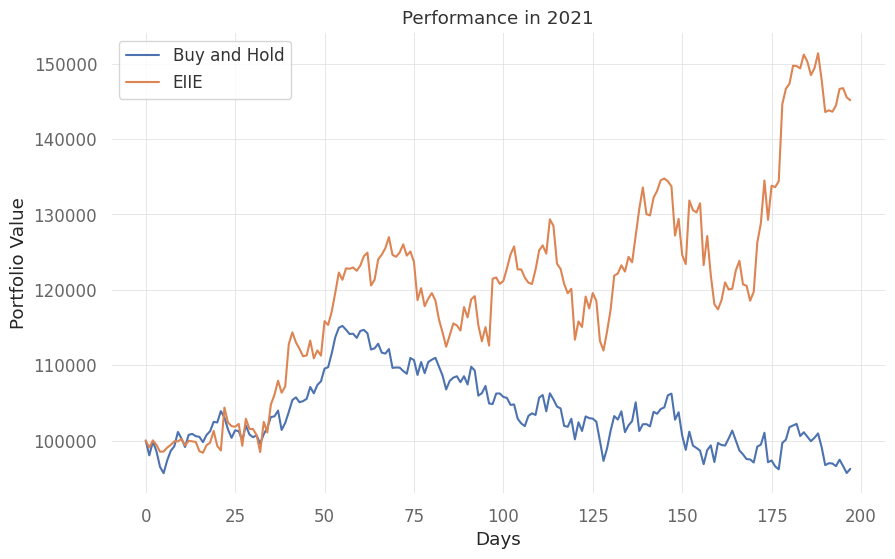

In [23]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

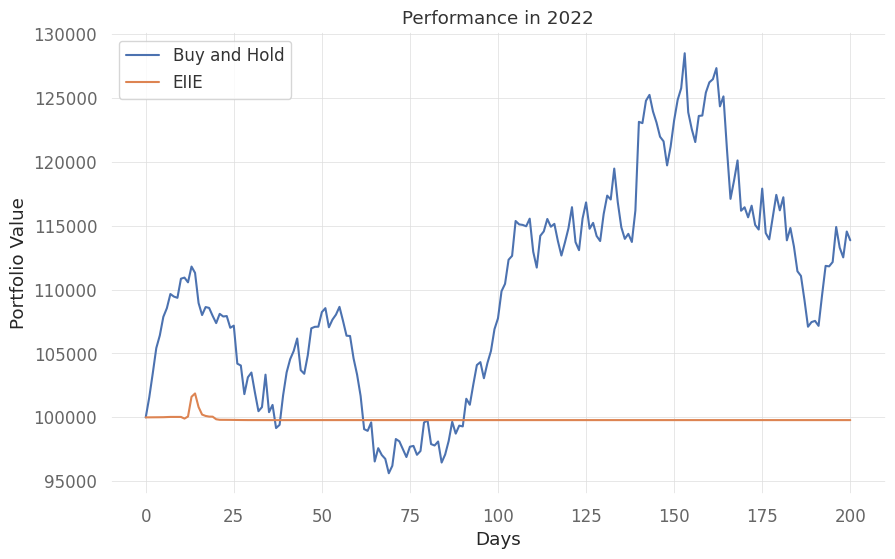

In [24]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

We can see that the agent is clearly overfitting, since it achieves great results in training period but is mediocre in testing periods. This is a common problem in this policy gradient algorithm. To deal with this, you can change the hyperparameters.